In [1]:
!pip install datasets
from datasets import Dataset
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    ElectraForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

# 1. 모델 설정
MODEL_NAME = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 라벨 인코더
le = LabelEncoder()

# 3. 학습 데이터 전처리
def preprocess_train(df):
    df.columns = df.columns.str.strip().str.lower()
    df["label"] = le.fit_transform(df["class"])
    return df.rename(columns={"conversation": "text"})

# 4. 테스트 데이터 전처리 (라벨 없음)
def preprocess_test(df):
    df.columns = df.columns.str.strip().str.lower()
    return df  # 'text' 컬럼 유지

# 5. 토크나이즈 함수
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# 6. 학습 데이터 경로
train_paths = {
    "aug_plus": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_plus_train.csv",
    "eda_only": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/eda_only.csv",
    "final_allclass": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/final_train_allclass_eda.csv"
}

# 7. 제출용 test 데이터 경로
test_url = "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/test.csv"

# 8. 학습 + 예측 + 제출 루프
for name, url in train_paths.items():
    print(f"\n===== [{name}] 학습 시작 =====")

    # 1) 학습 데이터 준비
    train_df = pd.read_csv(url)
    train_df = preprocess_train(train_df)
    train_dataset = Dataset.from_pandas(train_df)
    train_tokenized = train_dataset.map(tokenize_function, batched=True)

    # 2) 테스트셋 준비
    test_df = pd.read_csv(test_url)
    test_df = preprocess_test(test_df)
    test_dataset = Dataset.from_pandas(test_df)
    test_tokenized = test_dataset.map(tokenize_function, batched=True)

    # 3) 모델 초기화
    model = ElectraForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(le.classes_)
    ).to(device)

    # 4) 학습 설정
    training_args = TrainingArguments(
        output_dir=f"./results/{name}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        logging_dir=f"./logs/{name}",
        logging_steps=50
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized
    )

    # 5) 학습
    trainer.train()

    # 6) 예측
    predictions = trainer.predict(test_tokenized)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    decoded = le.inverse_transform(pred_labels)

    # 7) 제출 파일 저장
    submission = pd.DataFrame({
        "idx": test_df["idx"],
        "predicted_class": decoded
    })
    submission.to_csv(f"submission_{name}.csv", index=False)
    print(f"✅ submission_{name}.csv 저장 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


===== [aug_plus] 학습 시작 =====


Map:   0%|          | 0/14281 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bth0114 (bth0114-hanyang-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,1.448200
100,0.862000
150,0.542500
200,0.457100
250,0.401700
300,0.386300
350,0.293600
400,0.321200
450,0.380500
500,0.283200


✅ submission_aug_plus.csv 저장 완료!

===== [eda_only] 학습 시작 =====


Map:   0%|          | 0/4637 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.499900
100,0.914400
150,0.611900
200,0.525500
250,0.480100
300,0.437300
350,0.297600
400,0.370500
450,0.275500
500,0.328700


✅ submission_eda_only.csv 저장 완료!

===== [final_allclass] 학습 시작 =====


Map:   0%|          | 0/9274 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.506300
100,1.067300
150,0.654100
200,0.517400
250,0.494000
300,0.375300
350,0.388900
400,0.321000
450,0.325600
500,0.336200


✅ submission_final_allclass.csv 저장 완료!


In [2]:
from google.colab import files
files.download("submission_final_allclass.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
submission.to_csv(f"submission_{name}.csv", index=False, encoding='utf-8-sig')


In [4]:
import pandas as pd

df = pd.read_csv("submission_final_allclass.csv")
df.head()  # 상위 5개 행 미리보기


,idx,predicted_class
0,t_000,갈취 대화
1,t_001,직장 내 괴롭힘 대화
2,t_002,직장 내 괴롭힘 대화
3,t_003,기타 괴롭힘 대화
4,t_004,기타 괴롭힘 대화


In [5]:
# 1. class → label (숫자형)로 다시 인코딩
submission["target"] = le.transform(submission["predicted_class"])

# 2. 필요 없는 열 제거
submission = submission[["idx", "target"]]

# 3. CSV 저장 (utf-8-sig 권장)
submission.to_csv("submission_final_fixed.csv", index=False, encoding="utf-8-sig")


In [6]:
from google.colab import files
files.download("submission_final_fixed.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

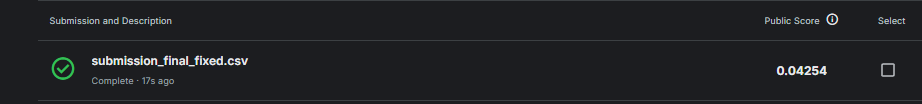

In [9]:
import pandas as pd

# GitHub에서 불러오기
url = "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/notebooks/taehoon/submission_final_fixed.csv"
df = pd.read_csv(url)

# 라벨 매핑 적용
label_mapping = {
    0: 1,
    1: 3,
    2: 4,
    3: 2,
    4: 0
}
df["target"] = df["target"].map(label_mapping)
df = df[["idx", "target"]]

# 파일 저장 (Jupyter 노트북 현재 경로에 저장됨)
filename = "submission_final_remapped__.csv"
df.to_csv(filename, index=False, encoding="utf-8-sig")

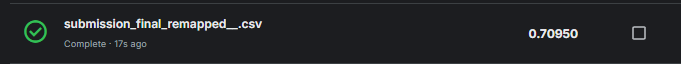